In [1]:
# ================================
# HÜCRE 1 – KÜTÜPHANELERİ YÜKLE (REGRESYON)
# Bu hücrede çalışmada kullanılacak tüm Python kütüphaneleri içe aktarılır.
# Ayrıca gereksiz uyarılar kapatılır.
# ================================

import warnings
warnings.filterwarnings('ignore')

# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn bileşenleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
from scipy.sparse import hstack
from xgboost import XGBRegressor

# PyTorch bileşenleri (MLP ve LSTM için)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Kütüphaneler yüklendi.")


Kütüphaneler yüklendi.


In [2]:
# ==============================================
# HÜCRE 2 – VERİYİ YÜKLE, TEMİZLE VE HEDEFİ OLUŞTUR (REGRESYON)
# Bu hücre:
# 1) CSV dosyasını okur
# 2) Başlığı (title) boş olan satırları siler
# 3) is_hourly sütununu 0 (Fixed) ve 1 (Hourly) olarak dönüştürür
# 4) Sadece Hourly ilanları tutar
# ==============================================

csv_path = "all_upwork_jobs_2024-02-07-2024-03-24.csv"

# CSV dosyasını oku
df = pd.read_csv(csv_path, low_memory=False)

# Başlığı (title) boş olan satırları at
df = df.dropna(subset=["title"]).copy()

# is_hourly sütununu 0/1'e çeviren fonksiyon
def map_hourly(v):
    s = str(v).strip().lower()
    if s in ["1", "true", "yes", "y", "hourly"]:
        return 1
    if s in ["0", "false", "no", "n", "fixed"]:
        return 0
    return np.nan

df["is_hourly"] = df["is_hourly"].apply(map_hourly)
df = df.dropna(subset=["is_hourly"]).copy()
df["is_hourly"] = df["is_hourly"].astype(int)

# Sadece hourly ilanlar (regresyon için)
df = df[df["is_hourly"] == 1].copy()

print("Veri boyutu (sadece Hourly):", df.shape)


Veri boyutu (sadece Hourly): (140936, 8)


In [3]:
# ===================================================
# HÜCRE 3 – ÖZELLİK OLUŞTURMA VE TRAIN/TEST AYIRIMI (REGRESYON)
# Bu hücre:
# 1) Metin ve sayısal özellikler üretir
# 2) TF-IDF ile başlıklardan kelime temelli özellik çıkarır
# 3) Tüm özellikleri birleştirip train/test olarak böler
# 4) Hedef değişken: avg_hourly (saatlik ücret)
# ===================================================

# Metin temelli basit özellikler
df["title_length"] = df["title"].astype(str).str.len()
df["word_count"]  = df["title"].astype(str).str.split().str.len()

# Bütçe ve saatlik ücretle ilgili bayraklar
df["has_budget"] = df["budget"].notna().astype(int)
df["has_hourly"] = df["hourly_low"].notna().astype(int)

# Saatlik ücret ortalaması ve bütçe
df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1)
df = df.dropna(subset=["avg_hourly"]).copy()

df["budget_filled"] = df["budget"].fillna(0)

# En sık görülen 10 ülkeyi bırak, diğerlerini "Other" yap
top_countries = df["country"].value_counts().head(10).index.tolist()
df["country_grouped"] = df["country"].apply(
    lambda x: x if x in top_countries else "Other"
).fillna("Unknown")

# Ülke isimlerini sayıya çevir
le_country = LabelEncoder()
df["country_encoded"] = le_country.fit_transform(df["country_grouped"])

# TF-IDF ile başlık metninden kelime özellikleri çıkar
tfidf = TfidfVectorizer(max_features=1000, stop_words="english")
X_text = tfidf.fit_transform(df["title"].astype(str))

# Sayısal özellik sütunları
num_cols = [
    "title_length", "word_count", "has_budget",
    "has_hourly", "country_encoded", "avg_hourly", "budget_filled"
]
X_num = df[num_cols].values

# Metin (seyrek) ve sayısal özellikleri birleştir
X = hstack([X_text, X_num])

# Hedef: avg_hourly (regresyon)
y = df["avg_hourly"].astype(float).values

# Train/Test ayırımı (stratify yok, çünkü regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Toplam özellik sayısı:", X.shape[1])
print("Train örnek sayısı:", X_train.shape[0])
print("Test örnek sayısı:",  X_test.shape[0])


Toplam özellik sayısı: 1007
Train örnek sayısı: 81937
Test örnek sayısı: 20485


In [4]:
# ============================================================
# HÜCRE 4 – SKLEARN REGRESYON MODELLERİ (LINEAR REGRESSION + XGBREGRESSOR)
# Bu hücre:
# 1) Linear Regression
# 2) XGBRegressor
# modellerini TEK parametre kombinasyonu ile eğitir.
# Çıktı: R2, MSE, RMSE, MAE, MAPE
# ============================================================

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(
        np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))
    ) * 100
    r2 = r2_score(y_true, y_pred)
    return r2, mse, rmse, mae, mape

print('\n' + '='*70)
print('SKLEARN REGRESYON MODELLERİ (HIZLI – LR + XGBR)')
print('='*70)

sklearn_results = []

# ----------------------------
# 1) Linear Regression
# ----------------------------
print('\n1) Linear Regression (tek kombinasyon)...')

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_lr)
sklearn_results.append({
    'Model': 'Linear Regression',
    'R2':   r2,
    'MSE':  mse,
    'RMSE': rmse,
    'MAE':  mae,
    'MAPE': mape
})

# ----------------------------
# 2) XGBRegressor
# ----------------------------
print('\n2) XGBRegressor (tek kombinasyon)...')

xgbr = XGBRegressor(
    random_state=42,
    n_estimators=80,
    max_depth=5,
    learning_rate=0.1,
    objective="reg:squarederror"
)

xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)

r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_xgbr)
sklearn_results.append({
    'Model': 'XGBRegressor',
    'R2':   r2,
    'MSE':  mse,
    'RMSE': rmse,
    'MAE':  mae,
    'MAPE': mape
})

# ----------------------------
# Sonuçları tabloya dök ve kaydet
# ----------------------------
sklearn_df = pd.DataFrame(sklearn_results).round(4)
print('\nSKLEARN REGRESYON PERFORMANSI (OSAMA)')
print(sklearn_df.to_string(index=False))

sklearn_df.to_csv('osama_sklearn_regression_models.csv', index=False)
print('\nosama_sklearn_regression_models.csv dosyası kaydedildi')



SKLEARN REGRESYON MODELLERİ (HIZLI – LR + XGBR)

1) Linear Regression (tek kombinasyon)...

2) XGBRegressor (tek kombinasyon)...

SKLEARN REGRESYON PERFORMANSI (OSAMA)
            Model     R2    MSE   RMSE    MAE   MAPE
Linear Regression 1.0000  0.000 0.0001 0.0000 0.0003
     XGBRegressor 0.9422 51.983 7.2099 0.5586 1.1957

osama_sklearn_regression_models.csv dosyası kaydedildi


In [5]:
# ======================================================
# HÜCRE 5 – PYTORCH İÇİN VERİ HAZIRLAMA (REGRESYON)
# Bu hücre:
# 1) Seyrek (sparse) X_train ve X_test matrislerini dense hale getirir
# 2) StandardScaler ile ölçekler
# 3) PyTorch DataLoader nesnesi oluşturur
# ======================================================

print("\n" + "="*70)
print("PYTORCH REGRESYON")
print("="*70)

# Seyrek matrisleri yoğun (dense) numpy dizisine çevir
X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense  = X_test.toarray().astype(np.float32)

# Hedef değişkeni numpy dizisine çevir
y_train_np = y_train.astype(np.float32)
y_test_np  = y_test.astype(np.float32)

# Özellikleri ölçekle (0 ortalama, 1 standart sapma)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled  = scaler.transform(X_test_dense)

# Cihaz seçimi (GPU varsa CUDA, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# PyTorch Dataset ve DataLoader
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train_np.reshape(-1, 1))
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,   # her iterasyonda 64 örnek
    shuffle=True
)

# Sonuçları saklamak için liste
pytorch_results = []

# Ortak kayıp fonksiyonu (MSE – Regression)
loss_fn = nn.MSELoss()



PYTORCH REGRESYON
Kullanılan cihaz: cpu


In [6]:
# ======================================================
# HÜCRE 6 – MLP REGRESYON MODELİNİ EĞİT
# Bu hücre:
# 1) Basit bir MLP (tam bağlantılı ağ) tanımlar
# 2) 5 epoch boyunca eğitir
# 3) Test seti üzerinde tahmin yapar ve REGRESYON metriklerini hesaplar
# ======================================================

print("\n1) MLP Regresyon modeli eğitiliyor (5 epoch)...")

class MLP(nn.Module):
    """
    Basit çok katmanlı algılayıcı (Multi Layer Perceptron) REGRESYON modeli.
    Giriş: TF-IDF + sayısal özellikler
    Çıkış: Gerçek değer (saatlik ücret tahmini)
    """
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1   = nn.Linear(input_size, 128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2   = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3   = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)   # Regression: Sigmoid yok
        return x

mlp_model = MLP(X_train_scaled.shape[1]).to(device)
optim_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_model.train()
for epoch in range(5):   # 5 epoch
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_mlp.zero_grad()
        out  = mlp_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_mlp.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp (MSE): {epoch_loss/len(train_loader):.4f}")

# Test seti üzerinde değerlendirme
mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = mlp_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()

r2, mse, rmse, mae, mape = regression_metrics(y_test_np, y_pred_mlp)

pytorch_results.append({
    "Model": "MLP",
    "Architecture": "128-64-1",
    "R2":   r2,
    "MSE":  mse,
    "RMSE": rmse,
    "MAE":  mae,
    "MAPE": mape
})



1) MLP Regresyon modeli eğitiliyor (5 epoch)...
Epoch 1/5 - Ortalama Kayıp (MSE): 369.8159
Epoch 2/5 - Ortalama Kayıp (MSE): 68.9471
Epoch 3/5 - Ortalama Kayıp (MSE): 52.2496
Epoch 4/5 - Ortalama Kayıp (MSE): 47.4403
Epoch 5/5 - Ortalama Kayıp (MSE): 43.7485


In [7]:
# ======================================================
# HÜCRE 7 – LSTM REGRESYON MODELİNİ EĞİT
# Bu hücre:
# 1) LSTM tabanlı bir REGRESYON modeli tanımlar
# 2) 5 epoch boyunca eğitir
# 3) Test seti üzerinde tahmin yapar ve REGRESYON metriklerini hesaplar
# Not: Aslında verimiz zamansal değil, fakat ödev kapsamında LSTM deneniyor.
# ======================================================

print("\n2) LSTM Regresyon modeli eğitiliyor (5 epoch)...")

class LSTMModel(nn.Module):
    """
    LSTM tabanlı REGRESYON modeli.
    Giriş: (batch_size, features) -> (batch_size, 1, features)
    """
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            batch_first=True,
            num_layers=1
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   # Regression: Sigmoid yok
        )

    def forward(self, x):
        x = x.unsqueeze(1)             # (batch, features) -> (batch, 1, features)
        _, (h, _) = self.lstm(x)
        x = self.fc(h[-1])
        return x

lstm_model = LSTMModel(X_train_scaled.shape[1]).to(device)
optim_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

lstm_model.train()
for epoch in range(5):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_lstm.zero_grad()
        out  = lstm_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_lstm.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp (MSE): {epoch_loss/len(train_loader):.4f}")

# Test seti değerlendirme
lstm_model.eval()
with torch.no_grad():
    y_pred_lstm = lstm_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()

r2, mse, rmse, mae, mape = regression_metrics(y_test_np, y_pred_lstm)

pytorch_results.append({
    "Model": "LSTM",
    "Architecture": "LSTM(64)-32-1",
    "R2":   r2,
    "MSE":  mse,
    "RMSE": rmse,
    "MAE":  mae,
    "MAPE": mape
})

pytorch_df = pd.DataFrame(pytorch_results).round(4)
print("\nPYTORCH REGRESYON PERFORMANSI (OSAMA)")
print(pytorch_df.to_string(index=False))

pytorch_df.to_csv("osama_pytorch_regression_models.csv", index=False)
print("\nosama_pytorch_regression_models.csv dosyası kaydedildi.")



2) LSTM Regresyon modeli eğitiliyor (5 epoch)...
Epoch 1/5 - Ortalama Kayıp (MSE): 763.0793
Epoch 2/5 - Ortalama Kayıp (MSE): 161.6880
Epoch 3/5 - Ortalama Kayıp (MSE): 85.1996
Epoch 4/5 - Ortalama Kayıp (MSE): 63.0368
Epoch 5/5 - Ortalama Kayıp (MSE): 52.6446

PYTORCH REGRESYON PERFORMANSI (OSAMA)
Model  Architecture     R2      MSE    RMSE    MAE      MAPE
  MLP      128-64-1 0.9748  22.6535  4.7596 3.3667 17.944401
 LSTM LSTM(64)-32-1 0.8758 111.7648 10.5719 4.3712 23.135900

osama_pytorch_regression_models.csv dosyası kaydedildi.


In [8]:
# ======================================================
# HÜCRE 8 – TÜM REGRESYON MODELLERİ İÇİN PERFORMANS ÖZETİ
# Bu hücre:
# 1) Sklearn ve PyTorch sonuçlarını tek tabloda toplar
# 2) CSV dosyasına kaydeder
# ======================================================

tum_sonuclar = sklearn_results + pytorch_results
tum_df = pd.DataFrame(tum_sonuclar).round(4)

print("\nTÜM REGRESYON MODELLERİ PERFORMANSI ÖZETİ (OSAMA)")
print(tum_df.to_string(index=False))

tum_df.to_csv("osama_tum_regresyon_modelleri_performans_ozeti.csv", index=False)
print("\nosama_tum_regresyon_modelleri_performans_ozeti.csv dosyası kaydedildi")



TÜM REGRESYON MODELLERİ PERFORMANSI ÖZETİ (OSAMA)
            Model     R2      MSE    RMSE    MAE    MAPE  Architecture
Linear Regression 1.0000   0.0000  0.0001 0.0000  0.0003           NaN
     XGBRegressor 0.9422  51.9830  7.2099 0.5586  1.1957           NaN
              MLP 0.9748  22.6535  4.7596 3.3667 17.9444      128-64-1
             LSTM 0.8758 111.7648 10.5719 4.3712 23.1359 LSTM(64)-32-1

osama_tum_regresyon_modelleri_performans_ozeti.csv dosyası kaydedildi


Kaydedildi: osama_regression_diagnostic_plots.png


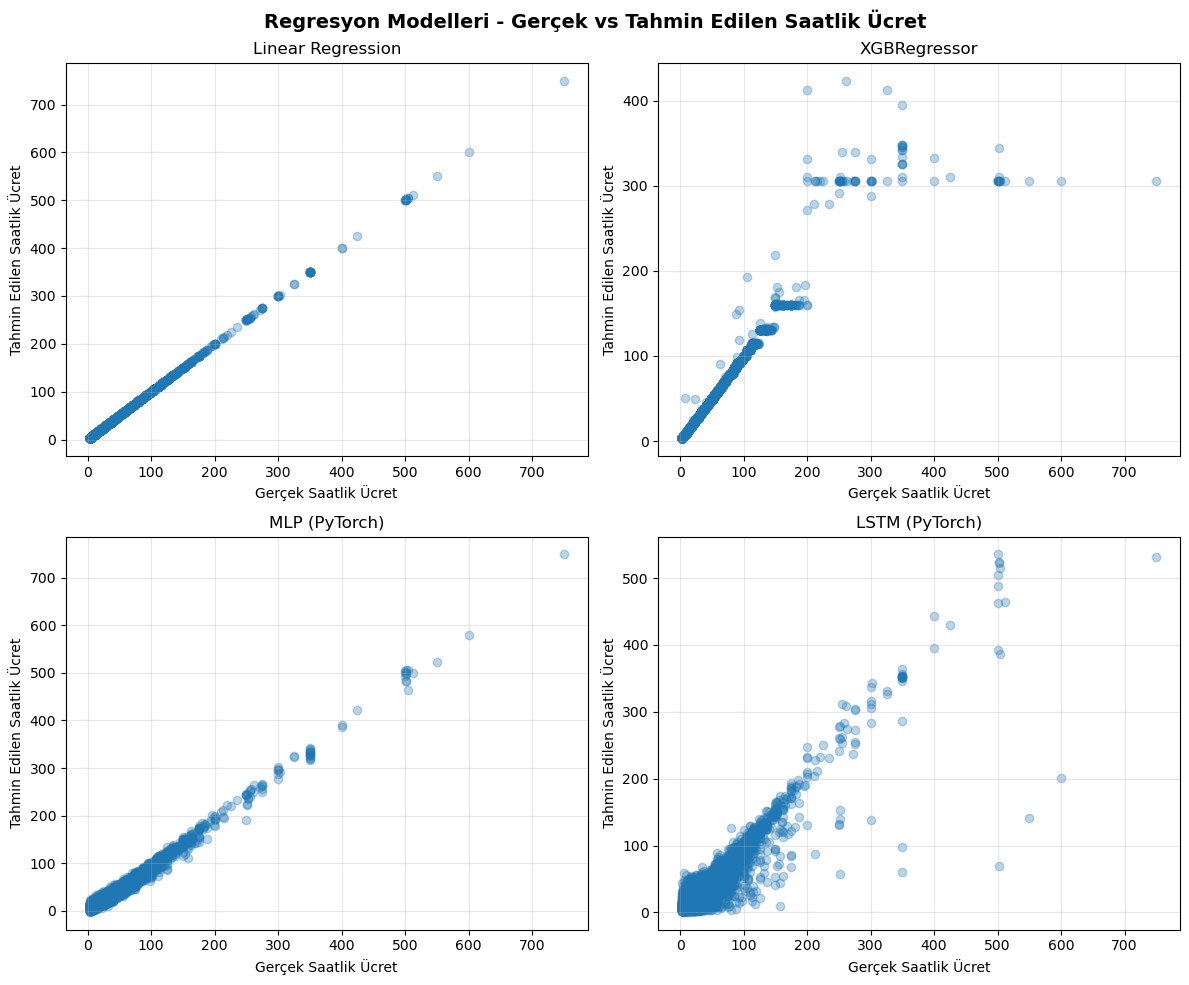

Kaydedildi: osama_regression_r2_comparison.png


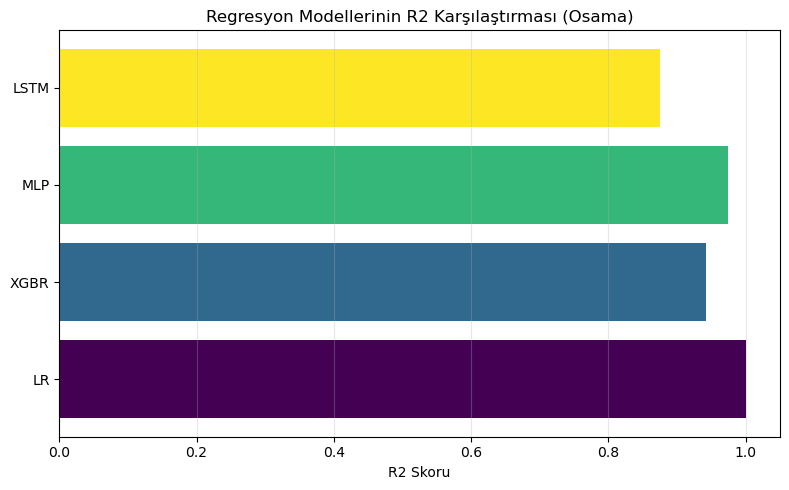

In [9]:
# ======================================================
# HÜCRE 9 – REGRESYON GÖRSELLERİ
# Bu hücre:
# 1) Her model için Gerçek vs Tahmin edilen değerleri scatter plot ile çizer
# 2) Modellerin R2 skorlarını bar grafik olarak gösterir
# ======================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Regresyon Modelleri - Gerçek vs Tahmin Edilen Saatlik Ücret", fontsize=14, fontweight="bold")

# Sklearn + PyTorch modelleri
model_predictions = [
    (y_pred_lr,    "Linear Regression", axes[0, 0]),
    (y_pred_xgbr,  "XGBRegressor",      axes[0, 1]),
    (y_pred_mlp,   "MLP (PyTorch)",     axes[1, 0]),
    (y_pred_lstm,  "LSTM (PyTorch)",    axes[1, 1]),
]

for y_hat, label, ax in model_predictions:
    ax.scatter(y_test_np, y_hat, alpha=0.3)
    ax.set_xlabel("Gerçek Saatlik Ücret")
    ax.set_ylabel("Tahmin Edilen Saatlik Ücret")
    ax.set_title(label)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("osama_regression_diagnostic_plots.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: osama_regression_diagnostic_plots.png")
plt.show()

# R2 Karşılaştırması
model_names = ["LR", "XGBR", "MLP", "LSTM"]
r2_scores = [
    r2_score(y_test_np, y_pred_lr),
    r2_score(y_test_np, y_pred_xgbr),
    r2_score(y_test_np, y_pred_mlp),
    r2_score(y_test_np, y_pred_lstm),
]

plt.figure(figsize=(8, 5))
plt.barh(model_names, r2_scores, color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
plt.xlabel("R2 Skoru")
plt.title("Regresyon Modellerinin R2 Karşılaştırması (Osama)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig("osama_regression_r2_comparison.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: osama_regression_r2_comparison.png")
plt.show()
